In [49]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [50]:
# !kaggle datasets download -d thedagger/pokemon-generation-one

In [51]:
# !unzip /content/pokemon-generation-one.zip -d /content


In [52]:
path = '/content/dataset/dataset'
BATCH_SIZE = 32
SEED_VALUE = 42

In [53]:
train = image_dataset_from_directory(
    directory = path,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=SEED_VALUE,
    label_mode = 'int',
    subset='training',  # Training split
    validation_split = 0.2,
    image_size = (128,128)
)
val = image_dataset_from_directory(
    directory = path,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=SEED_VALUE,
    label_mode = 'int',
    subset='validation',
    validation_split = 0.2,
    image_size = (128,128)
)

class_names = train.class_names
class_idex = {s:i for i,s in enumerate(class_names)}
print(class_idex)

Found 10658 files belonging to 149 classes.
Using 8527 files for training.
Found 10658 files belonging to 149 classes.
Using 2131 files for validation.
{'Abra': 0, 'Aerodactyl': 1, 'Alakazam': 2, 'Arbok': 3, 'Arcanine': 4, 'Articuno': 5, 'Beedrill': 6, 'Bellsprout': 7, 'Blastoise': 8, 'Bulbasaur': 9, 'Butterfree': 10, 'Caterpie': 11, 'Chansey': 12, 'Charizard': 13, 'Charmander': 14, 'Charmeleon': 15, 'Clefable': 16, 'Clefairy': 17, 'Cloyster': 18, 'Cubone': 19, 'Dewgong': 20, 'Diglett': 21, 'Ditto': 22, 'Dodrio': 23, 'Doduo': 24, 'Dragonair': 25, 'Dragonite': 26, 'Dratini': 27, 'Drowzee': 28, 'Dugtrio': 29, 'Eevee': 30, 'Ekans': 31, 'Electabuzz': 32, 'Electrode': 33, 'Exeggcute': 34, 'Exeggutor': 35, 'Farfetchd': 36, 'Fearow': 37, 'Flareon': 38, 'Gastly': 39, 'Gengar': 40, 'Geodude': 41, 'Gloom': 42, 'Golbat': 43, 'Goldeen': 44, 'Golduck': 45, 'Golem': 46, 'Graveler': 47, 'Grimer': 48, 'Growlithe': 49, 'Gyarados': 50, 'Haunter': 51, 'Hitmonchan': 52, 'Hitmonlee': 53, 'Horsea': 54, 'Hyp

<h3>Show Sample Images from training set.</h3>

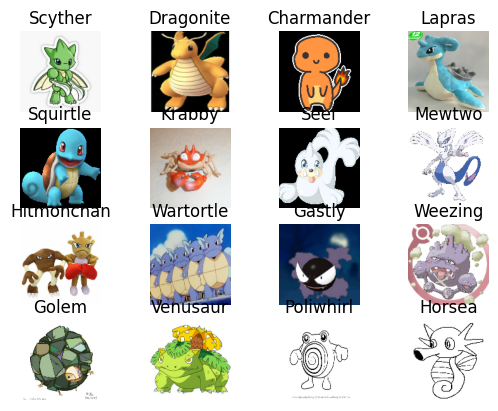

In [54]:
plt.Figure(figsize=(18,10))
num_row = 4
num_col = 4
for image,label in train.take(1):
    for i in range(num_row*num_col):
        ax = plt.subplot(num_row,num_col,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        truth_idx = label[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis('off')



<h3>Preprocessing.</h3>

In [55]:
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Resizing

# Apply the rescaling layer to your datasets
train_pre = train.map(lambda x, y: (preprocess_input(x), y))
val_pre = val.map(lambda x, y: (preprocess_input(x), y))

train_pre = train_pre.map(lambda x, y: (Resizing(128, 128)(x), y))
val_pre = val_pre.map(lambda x, y: (Resizing(128, 128)(x), y))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])
# Apply augmentation to training dataset only
train_pre = train_pre.map(lambda x, y: (data_augmentation(x, training=True), y))

train_pre = train_pre.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_pre = val_pre.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [56]:
class_counts = {class_name: 0 for class_name in class_names}
for _, labels in train:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

print("Class counts:", class_counts)


Class counts: {'Abra': 33, 'Aerodactyl': 78, 'Alakazam': 40, 'Arbok': 50, 'Arcanine': 49, 'Articuno': 46, 'Beedrill': 42, 'Bellsprout': 52, 'Blastoise': 49, 'Bulbasaur': 230, 'Butterfree': 52, 'Caterpie': 39, 'Chansey': 40, 'Charizard': 41, 'Charmander': 233, 'Charmeleon': 52, 'Clefable': 45, 'Clefairy': 54, 'Cloyster': 49, 'Cubone': 46, 'Dewgong': 49, 'Diglett': 43, 'Ditto': 37, 'Dodrio': 51, 'Doduo': 39, 'Dragonair': 52, 'Dragonite': 50, 'Dratini': 84, 'Drowzee': 48, 'Dugtrio': 59, 'Eevee': 37, 'Ekans': 40, 'Electabuzz': 42, 'Electrode': 54, 'Exeggcute': 45, 'Exeggutor': 57, 'Farfetchd': 57, 'Fearow': 91, 'Flareon': 47, 'Gastly': 40, 'Gengar': 48, 'Geodude': 47, 'Gloom': 44, 'Golbat': 55, 'Goldeen': 46, 'Golduck': 48, 'Golem': 52, 'Graveler': 44, 'Grimer': 49, 'Growlithe': 54, 'Gyarados': 55, 'Haunter': 49, 'Hitmonchan': 49, 'Hitmonlee': 46, 'Horsea': 53, 'Hypno': 52, 'Ivysaur': 46, 'Jigglypuff': 57, 'Jolteon': 57, 'Jynx': 50, 'Kabuto': 42, 'Kabutops': 46, 'Kadabra': 49, 'Kakuna': 56

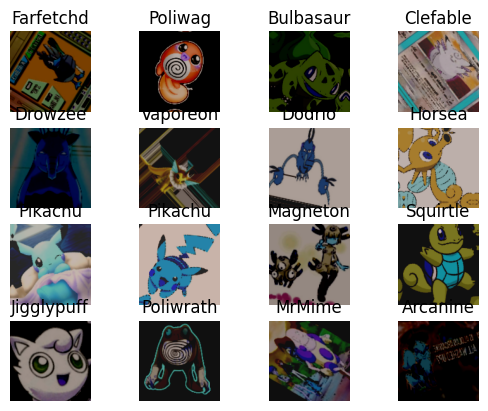

In [57]:
#checking images
plt.Figure(figsize=(18,10))
num_row = 4
num_col = 4
for image,label in train_pre.take(1):
    for i in range(num_row*num_col):
        ax = plt.subplot(num_row,num_col,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        truth_idx = label[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis('off')



In [58]:
from collections import Counter

# Your class counts
class_counts_compute = Counter(class_counts)

# Total number of images
total_samples = sum(class_counts_compute.values())

# Number of unique classes
num_classes = len(class_counts_compute)

# Compute class weights
class_weights = {
    class_id: total_samples / (num_classes * count)
    for class_id, count in class_counts_compute.items()
}

print("Class Weights:", class_weights)


Class Weights: {'Abra': 1.7341875127110027, 'Aerodactyl': 0.7336947169161935, 'Alakazam': 1.4307046979865772, 'Arbok': 1.1445637583892618, 'Arcanine': 1.1679222024380222, 'Articuno': 1.2440910417274584, 'Beedrill': 1.3625759028443591, 'Bellsprout': 1.10054207537429, 'Blastoise': 1.1679222024380222, 'Bulbasaur': 0.24881820834549168, 'Butterfree': 1.10054207537429, 'Caterpie': 1.467389433832387, 'Chansey': 1.4307046979865772, 'Charizard': 1.3958094614503191, 'Charmander': 0.2456145404268802, 'Charmeleon': 1.10054207537429, 'Clefable': 1.2717375093214018, 'Clefairy': 1.059781257767835, 'Cloyster': 1.1679222024380222, 'Cubone': 1.2440910417274584, 'Dewgong': 1.1679222024380222, 'Diglett': 1.3308880911503043, 'Ditto': 1.5467077816071104, 'Dodrio': 1.1221213317541783, 'Doduo': 1.467389433832387, 'Dragonair': 1.10054207537429, 'Dragonite': 1.1445637583892618, 'Dratini': 0.6812879514221796, 'Drowzee': 1.1922539149888143, 'Dugtrio': 0.9699692867705608, 'Eevee': 1.5467077816071104, 'Ekans': 1.43

In [59]:
# Create a class index mapping
class_to_index = {pokemon: index for index, pokemon in enumerate(class_weights.keys())}

# Create a new class weights dictionary with indices
class_weights_by_index = {class_to_index[pokemon]: weight for pokemon, weight in class_weights.items()}

print(class_weights_by_index)

{0: 1.7341875127110027, 1: 0.7336947169161935, 2: 1.4307046979865772, 3: 1.1445637583892618, 4: 1.1679222024380222, 5: 1.2440910417274584, 6: 1.3625759028443591, 7: 1.10054207537429, 8: 1.1679222024380222, 9: 0.24881820834549168, 10: 1.10054207537429, 11: 1.467389433832387, 12: 1.4307046979865772, 13: 1.3958094614503191, 14: 0.2456145404268802, 15: 1.10054207537429, 16: 1.2717375093214018, 17: 1.059781257767835, 18: 1.1679222024380222, 19: 1.2440910417274584, 20: 1.1679222024380222, 21: 1.3308880911503043, 22: 1.5467077816071104, 23: 1.1221213317541783, 24: 1.467389433832387, 25: 1.10054207537429, 26: 1.1445637583892618, 27: 0.6812879514221796, 28: 1.1922539149888143, 29: 0.9699692867705608, 30: 1.5467077816071104, 31: 1.4307046979865772, 32: 1.3625759028443591, 33: 1.059781257767835, 34: 1.2717375093214018, 35: 1.0040032968326857, 36: 1.0040032968326857, 37: 0.6288811859281658, 38: 1.2176210195630444, 39: 1.4307046979865772, 40: 1.1922539149888143, 41: 1.2176210195630444, 42: 1.300640

In [64]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
# Load the pre-trained ResNet50 model without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = True

# Unfreeze only the top 4 layers (you can adjust this based on your needs)
for layer in base_model.layers[:-10]:  # Freeze all but the last few layers
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.6),
    layers.Dense(len(class_names), activation='softmax')
])


In [65]:
from tensorflow.keras.optimizers import RMSprop

# Recompile the model with a smaller learning rate
model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 149)                 │          19,221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,886,229 (91.12 MB)

 Trainable params: 1,354,005 (5.17 MB)

 Non-trainable params: 22,532,224 (85.95 MB)

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_pre,
    validation_data = val,
    epochs = 100,
    class_weight=class_weights_by_index,
    callbacks=[early_stopping]
)

Epoch 1/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 50s 139ms/step - accuracy: 0.0078 - loss: 5.8343 - val_accuracy: 0.0070 - val_loss: 5.5008
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 59s 69ms/step - accuracy: 0.0089 - loss: 5.7143 - val_accuracy: 0.0066 - val_loss: 5.6191
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.0103 - loss: 5.6056 - val_accuracy: 0.0070 - val_loss: 5.5913
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.0134 - loss: 5.5060 - val_accuracy: 0.0080 - val_loss: 5.5590
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.0157 - loss: 5.4398 - val_accuracy: 0.0089 - val_loss: 5.5293
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.0201 - loss: 5.3295 - val_accuracy: 0.0099 - val_loss: 5.4960
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.0234 - loss: 5.1941 - val_accuracy: 0.0108 - val_loss: 5.4699
Epoch 8/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.0275 - loss: 

In [ ]:
y_pred = model.predict(val_pre)
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification, get the class with max probability
print(y_pred_classes)


In [ ]:
from sklearn.metrics import classification_report

true_labels = []
for images, labels in val_pre:
    true_labels.extend(labels.numpy())  # Convert labels to a list of true labels


report = classification_report(true_labels, y_pred_classes)
print("Classification Report:\n", report)



In [ ]:
model.save('/content/epoch_100.keras')